# Decision Tree Induction and Model Performance Evaluation

## 2021-0407 CIS 600 Fundamental Data & Knowledge Mining

### Tanay Nagireddy

Apply Decision Tree Induction algorithm on a weather forecast problem. It is a binary classification problem to predict whether or not a location will get rain the next day.

### Libraries and Data

In [1]:
# data
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# graphing
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from string import ascii_letters

# collection
from collections import Counter, OrderedDict, namedtuple
import itertools

# statistical
import math
from scipy.stats import normaltest, shapiro
import scipy.stats as ss

# modelling
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay # plot_roc_curve # plot_confusion_matrix

In [2]:
# plots visualizations below cell
%matplotlib inline

In [3]:
# ignore warnings that appear for HTML output
import warnings
warnings.simplefilter('ignore')

In [4]:
# import training and testing data
data_train = pd.read_csv("Weather Forecast Training.csv")
data_test = pd.read_csv("Weather Forecast Testing.csv")

### Functions

The following functions provide a clean way to compute/conduct necessary data analysis, please see the function headers for information about each function.

In [5]:
def splitByType(df):
    """
    Description: computes two dataframes based on the type of the columns (int64, float64, object)
    Input: dataframe containing cleansed data
    Return: dataframe containing only object type columns, and dataframe excluding only object type columns 
    """
    non_object_type = df.select_dtypes(exclude=['object'])  # int64, float64, etc.
    object_type = df.select_dtypes(include=['object'])  # string, etc.
    return {'non_object_type':non_object_type, 'object_type':object_type}

In [6]:
def displayBoxPlots(df):
    """
    Description: plots the boxplots of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of box plots
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1//number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(y=df[l[i]],color='green',orient='v')
        plt.tight_layout()

In [7]:
def displayDistribution(df):
    """
    Description: plots the distribution plots/histograms of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of distribution plots/histograms
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1//number_of_columns
    plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.distplot(df[l[i]],kde=True)

In [8]:
def displayCorrelationHeatMap(df_corr):
    """
    Description: display a correlation matrix for the dataframe of correlation values (depending on the statistic)
    Input: dataframe of correlation values
    Result: heatmap of correlation matrix
    """
    plt.figure(figsize=(20,12))

    mask = np.triu(np.ones_like(df_corr, dtype=np.bool_))

    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()

    sns.heatmap(corr, mask=mask, cmap='viridis', annot=True)

## Section 1: Data preparation

### Summary statistics

 * displaying the dimensions of the dataframes

In [9]:
print(f"Training data: {data_train.shape} and Testing data: {data_test.shape}")

Training data: (51978, 16) and Testing data: (12994, 16)


 There are 16 attributes including the target class/variable, let's check out the data type distribution of these attributes while displaying other information about the training dataset.

In [10]:
print("number of attributes: \n non_object_type: {} \n object_type: {}".format(len(splitByType(data_train)['non_object_type'].columns), len(splitByType(data_train)['object_type'].columns)))

number of attributes: 
 non_object_type: 11 
 object_type: 5


 * taking a look at which attributes/features/predictors are present in each of the categories:

In [11]:
splitByType(data_train)['non_object_type'].columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed', 'Humidity', 'Pressure', 'Cloud', 'Temp'],
      dtype='object')

In [12]:
splitByType(data_train)['object_type'].columns

Index(['Location', 'WindGustDir', 'WindDir', 'RainToday', 'RainTomorrow'], dtype='object')

 * displaying the first 5 rows of the dataframe

In [13]:
data_train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No


and the counts of the same dataset on a more granular level where 'O' stands for object type with non_object_type being split into int and float types:

In [14]:
Counter(data_train.dtypes)

Counter({dtype('O'): 5, dtype('float64'): 11})

So we can see that majority of the relevant attributes are of float type which is great.

 * displaying a summary of column information for the dataset

In [15]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51978 entries, 0 to 51977
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       51978 non-null  object 
 1   MinTemp        51694 non-null  float64
 2   MaxTemp        51849 non-null  float64
 3   Rainfall       51231 non-null  float64
 4   Evaporation    29425 non-null  float64
 5   Sunshine       27103 non-null  float64
 6   WindGustDir    48380 non-null  object 
 7   WindGustSpeed  48407 non-null  float64
 8   WindDir        50465 non-null  object 
 9   WindSpeed      50954 non-null  float64
 10  Humidity       50549 non-null  float64
 11  Pressure       46912 non-null  float64
 12  Cloud          31848 non-null  float64
 13  Temp           50915 non-null  float64
 14  RainToday      51231 non-null  object 
 15  RainTomorrow   51978 non-null  object 
dtypes: float64(11), object(5)
memory usage: 6.3+ MB


Immediately, we can see that there are some values missing, let's understand the scale of these missing values:

In [16]:
print(f"There are a total of {data_train.isna().sum().sum()} missing values.")

There are a total of 86729 missing values.


This is a significant number, and needs to be addressed before we can check for outliers.

In [17]:
print(f"Here is a breakdown by column for missing values by column (# of columns = {len(data_train.isna().sum())}): \n")
data_train.isna().sum()

Here is a breakdown by column for missing values by column (# of columns = 16): 



Location             0
MinTemp            284
MaxTemp            129
Rainfall           747
Evaporation      22553
Sunshine         24875
WindGustDir       3598
WindGustSpeed     3571
WindDir           1513
WindSpeed         1024
Humidity          1429
Pressure          5066
Cloud            20130
Temp              1063
RainToday          747
RainTomorrow         0
dtype: int64

### Dealing with Data Issues

Let's see if these is any correlation between evaporation, sunshine, and cloud as these attributes/features have extremely high null value counts.

But before this, let's do the mapping of the categorical values for further processing.

In [18]:
mapped_columns = list(splitByType(data_train)['object_type'].columns)[:-1]

In [19]:
for col in mapped_columns:
    data_train[col] = data_train[col].astype('category')

In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51978 entries, 0 to 51977
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Location       51978 non-null  category
 1   MinTemp        51694 non-null  float64 
 2   MaxTemp        51849 non-null  float64 
 3   Rainfall       51231 non-null  float64 
 4   Evaporation    29425 non-null  float64 
 5   Sunshine       27103 non-null  float64 
 6   WindGustDir    48380 non-null  category
 7   WindGustSpeed  48407 non-null  float64 
 8   WindDir        50465 non-null  category
 9   WindSpeed      50954 non-null  float64 
 10  Humidity       50549 non-null  float64 
 11  Pressure       46912 non-null  float64 
 12  Cloud          31848 non-null  float64 
 13  Temp           50915 non-null  float64 
 14  RainToday      51231 non-null  category
 15  RainTomorrow   51978 non-null  object  
dtypes: category(4), float64(11), object(1)
memory usage: 5.0+ MB


We can see that all of the object type have been turned into category type (except for the target variable).

Now let's map these columns to numerical codes.

In [21]:
for col in mapped_columns:
    code_col = col + "_codes"
    data_train[code_col] = data_train[col].cat.codes

In [22]:
data_train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow,Location_codes,WindGustDir_codes,WindDir_codes,RainToday_codes
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes,26,10,10,0
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No,28,13,15,0
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes,14,9,12,1
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes,6,15,14,0
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No,43,5,2,0


We can see that all the mapped columns have been added at the end of the dataset.

Now let's look at the correlation using spearman's and kendall's methods.

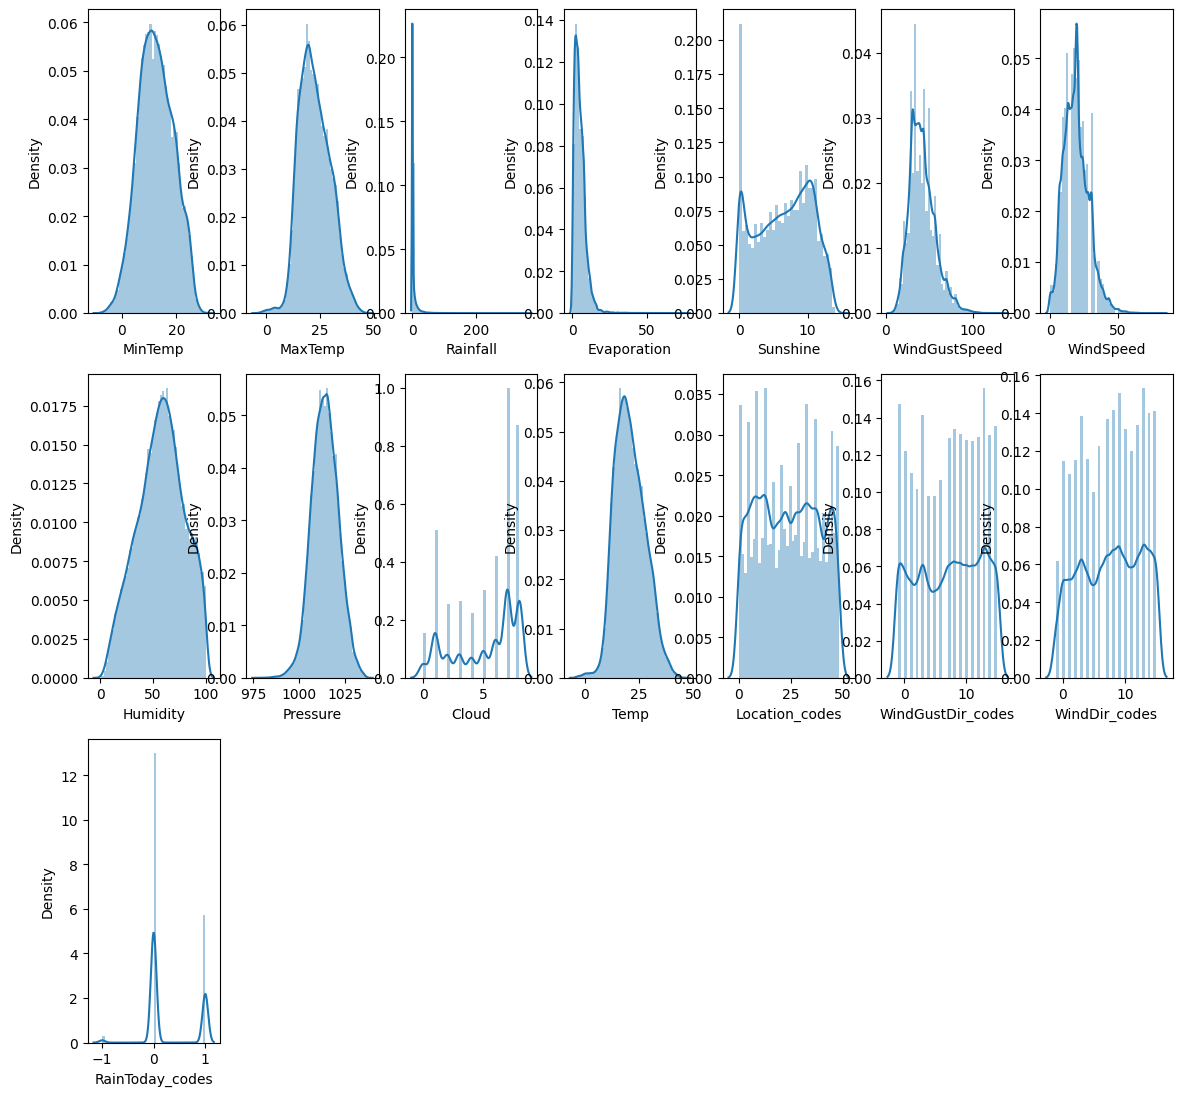

In [23]:
displayDistribution(data_train.select_dtypes(exclude=['category','object']))

Looking at the distribution plots, we can see that applying the default pearson correlation method is not appropriate as ALL distributions are not Gaussian-like. We can also proceed to correlation without replacing the null values as pandas as insensitive to missing data when computing correlation.

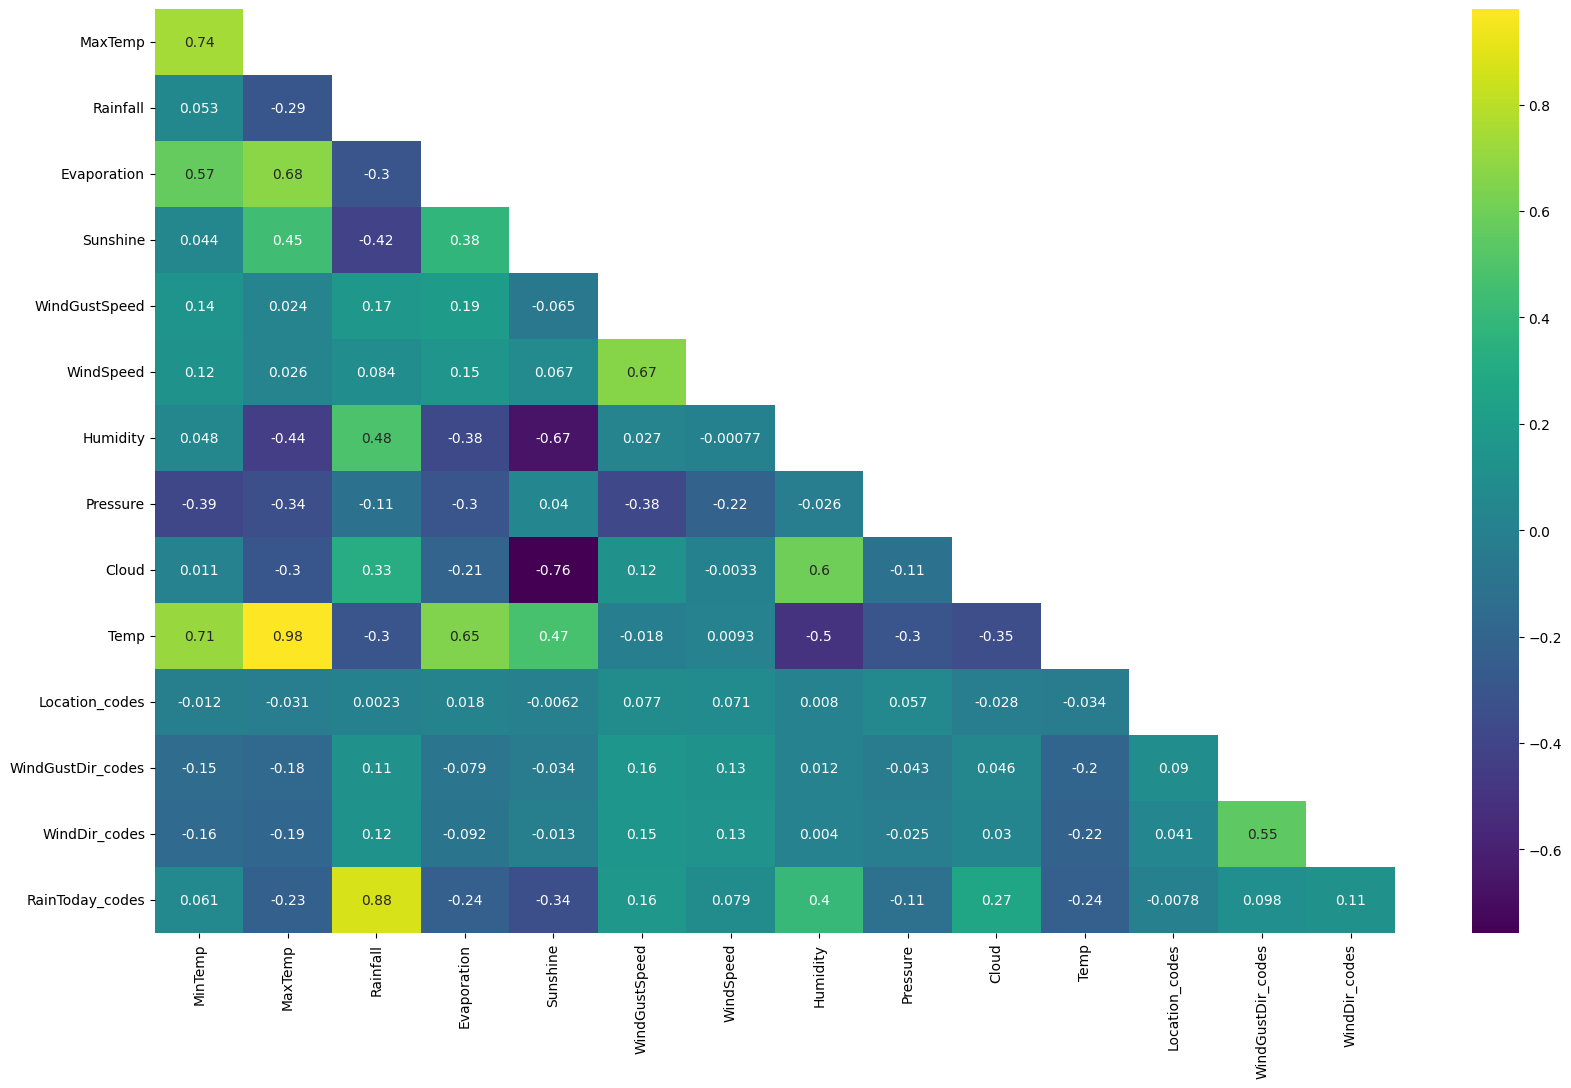

In [24]:
data_train_corr = data_train.select_dtypes(exclude=['category','object'])
displayCorrelationHeatMap(data_train_corr.corr(method='spearman'))

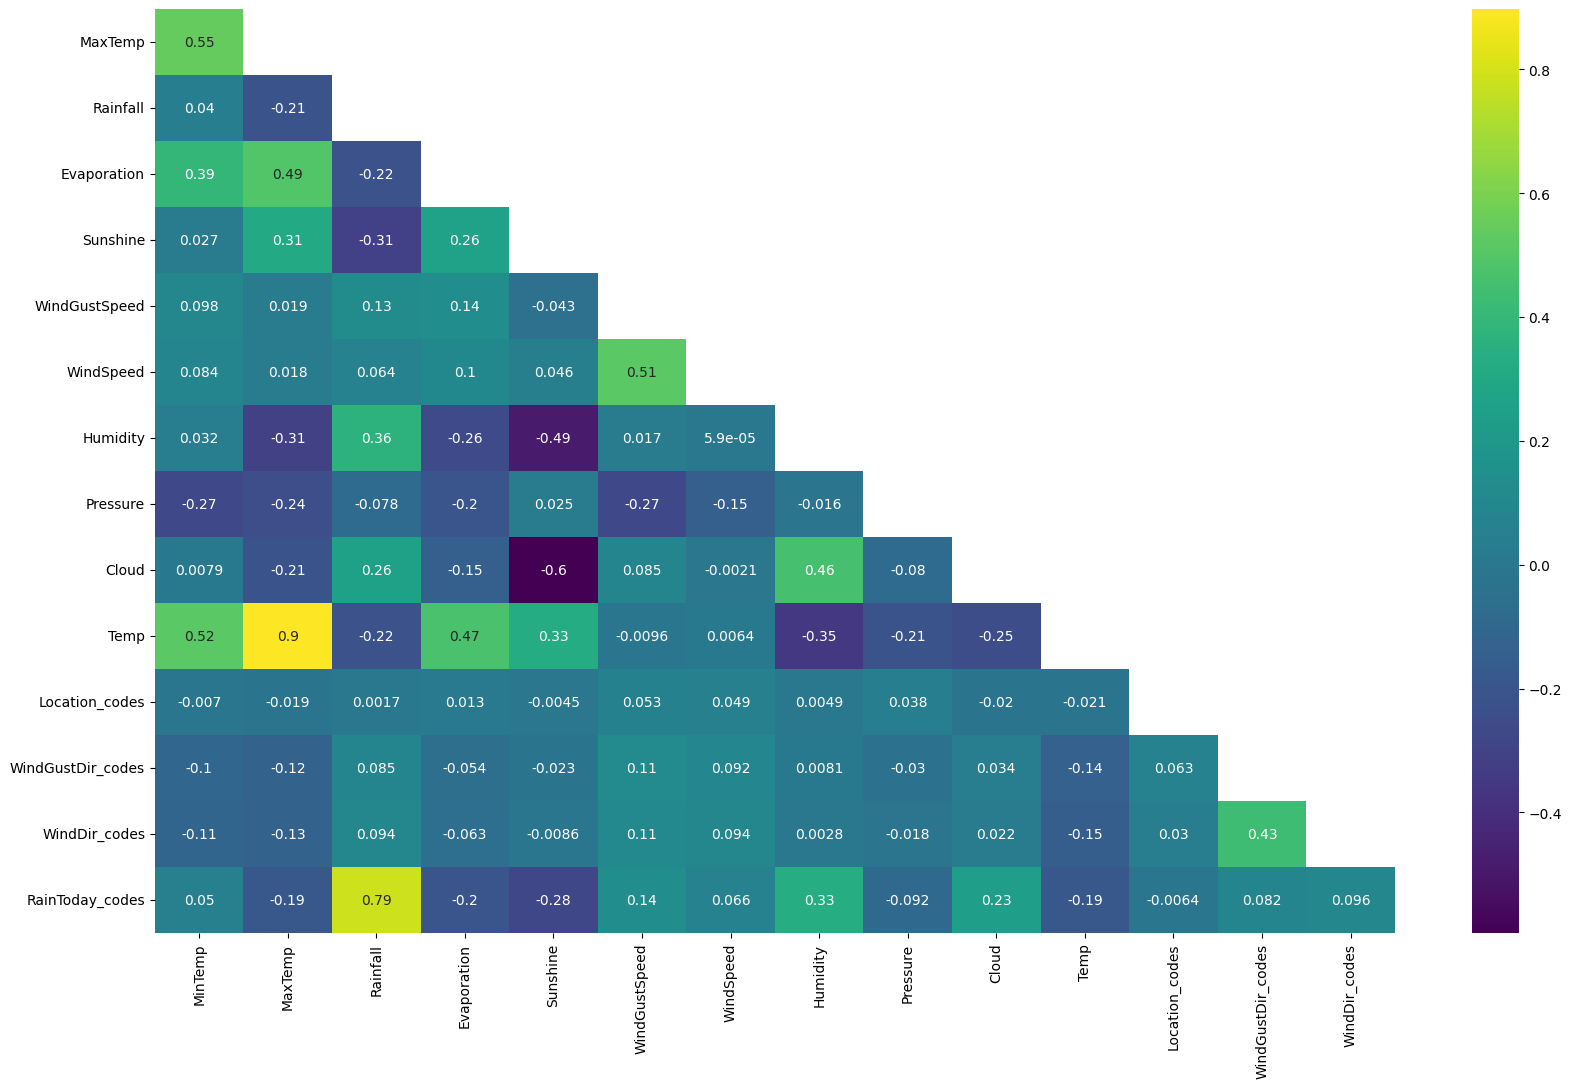

In [25]:
displayCorrelationHeatMap(data_train_corr.corr(method='kendall'))

 * As we can see from both methods, "Temp" is highly/strongly correlated with MinTemp, MaxTemp, Evaporation, and moderately correlated to Sunshine so we can proceed with dropping these columns leaving "Temp".
 * Similarily, Rainfall is also highly/strongly correlated with RainToday, and so we will drop RainToday as it is more accurate to replace Rainfall null values with the mean for that location rather then filling the same with "Yes" or "No".
 * Also, we will drop WindGustSpeed and WindGustDir as they are not as generic as WindSpeed and WindDir but are highly/strongly correlated with them respectively.
 * Additionally, with Cloud being related to humidity, we will drop Cloud due to the large number of null values as compared to humidity.

Let's have a look at the missing values for RainToday and Rainfall.

In [26]:
data_train[(data_train['Rainfall'].isnull() == True) & (data_train['RainToday'].isnull() == True)][:10]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow,Location_codes,WindGustDir_codes,WindDir_codes,RainToday_codes
52,MountGinini,3.2,12.7,NaN,NaN,NaN,SE,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,23,9,-1,-1
66,Adelaide,9.4,16.8,NaN,NaN,9.1,NNW,54.0,NNW,28.0,47.0,1009.5,NaN,16.5,NaN,Yes,0,6,6,-1
80,Uluru,15.7,26.2,NaN,NaN,NaN,SSE,30.0,SSE,17.0,43.0,1012.6,NaN,25.3,NaN,No,41,10,10,-1
95,PearceRAAF,18.1,22.9,NaN,NaN,1.6,E,72.0,SE,20.0,94.0,1003.8,8.0,18.3,NaN,Yes,29,0,9,-1
116,Melbourne,6.7,12.8,NaN,0.4,0.4,N,46.0,N,30.0,70.0,1014.9,NaN,12.2,NaN,Yes,18,3,3,-1
122,Williamtown,7.4,19.8,NaN,NaN,NaN,NW,20.0,SSE,13.0,69.0,1025.4,1.0,18.1,NaN,Yes,45,7,10,-1
224,Adelaide,7.2,18.1,NaN,NaN,5.6,NNW,39.0,NNW,19.0,37.0,1012.4,NaN,17.8,NaN,Yes,0,6,6,-1
317,Wollongong,17.7,22.3,NaN,NaN,NaN,SSE,54.0,S,37.0,80.0,1014.3,7.0,17.0,NaN,Yes,47,10,8,-1
500,Walpole,12.2,18.5,NaN,NaN,NaN,NaN,NaN,WNW,17.0,59.0,1011.7,NaN,17.3,NaN,Yes,43,-1,14,-1
565,PearceRAAF,9.0,19.0,NaN,NaN,1.4,SW,20.0,S,2.0,59.0,1023.3,2.0,18.5,NaN,Yes,29,12,8,-1


RainToday has null values that are difficult to impute, encouraging us to drop this feature.

In [27]:
data_train_reduced = data_train.drop(columns=[
    "MinTemp",
    "MaxTemp",
    "Evaporation",
    "Sunshine",
    "RainToday",
    "RainToday_codes",
    "WindGustSpeed",
    "WindGustDir",
    "WindGustDir_codes",
    "Location",
    "WindDir",
    "Cloud"
])

Now that the features have been dropped, let's take a look at the information and the remaining null value counts for this limited set of features.

In [28]:
data_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51978 entries, 0 to 51977
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rainfall        51231 non-null  float64
 1   WindSpeed       50954 non-null  float64
 2   Humidity        50549 non-null  float64
 3   Pressure        46912 non-null  float64
 4   Temp            50915 non-null  float64
 5   RainTomorrow    51978 non-null  object 
 6   Location_codes  51978 non-null  int8   
 7   WindDir_codes   51978 non-null  int8   
dtypes: float64(5), int8(2), object(1)
memory usage: 2.5+ MB


In [29]:
data_train_reduced.isna().sum()

Rainfall           747
WindSpeed         1024
Humidity          1429
Pressure          5066
Temp              1063
RainTomorrow         0
Location_codes       0
WindDir_codes        0
dtype: int64

Let's have a look at some basic stats.

In [30]:
data_train_reduced.describe()

,Rainfall,WindSpeed,Humidity,Pressure,Temp,Location_codes,WindDir_codes
count,51231.000000,50954.000000,50549.000000,46912.000000,50915.000000,51978.000000,51978.000000
mean,3.639494,19.092299,57.432214,1014.273338,20.845623,23.654238,7.601639
std,11.009628,9.157505,21.833045,7.278733,6.938471,14.180857,4.751900
min,0.000000,0.000000,1.000000,977.100000,-4.400000,0.000000,-1.000000
25%,0.000000,13.000000,42.000000,1009.300000,15.700000,11.000000,3.000000
50%,0.000000,19.000000,58.000000,1014.200000,20.200000,23.000000,8.000000
75%,2.200000,24.000000,73.000000,1019.200000,25.600000,36.000000,12.000000
max,371.000000,83.000000,100.000000,1037.800000,46.100000,48.000000,15.000000


In [31]:
round((len(data_train_reduced[data_train_reduced['Rainfall'] == 0])/len(data_train_reduced))*100,0)

54.0

To deal with the null values for Rainfall, we need to replace these values with their respective means, and with at least 50% being zero (54% exactly), this percentage makes it more important to replace these values with the mean for that particular location.

Since Decision Trees are robust/insensitive to outliers we can proceed replacing null values without explicitly correcting them, although winsorizing the data could help with better mean values for location groups.

In [32]:
list(data_train_reduced.select_dtypes(exclude='object').columns[:-2])

['Rainfall', 'WindSpeed', 'Humidity', 'Pressure', 'Temp']

In [33]:
for col in data_train_reduced.select_dtypes(exclude='object').columns[:-2]:
    data_train_reduced[col] = data_train_reduced.groupby('Location_codes')[col].transform(lambda x: x.fillna(x.mean()))
    print(f"{col} : {data_train_reduced[col].isna().sum()}")

Rainfall : 0
WindSpeed : 0
Humidity : 0
Pressure : 4253
Temp : 0


In [34]:
data_train_reduced.isna().sum()

Rainfall             0
WindSpeed            0
Humidity             0
Pressure          4253
Temp                 0
RainTomorrow         0
Location_codes       0
WindDir_codes        0
dtype: int64

It looks like Pressure has 4235 null values cannot be replaced with the mean by their respective location groups, and so we will proceed with replacing these values with the overall mean instead.

In [35]:
data_train_reduced[data_train_reduced['Pressure'].isnull() == True]['Location_codes'].unique()

array([23, 24, 30, 36], dtype=int8)

Looks like these locations do not have values for Pressure, and so we will replace the pressure null values with the overall mean for the feature.

In [36]:
data_train_reduced['Pressure'].mean()

1014.260419188583

In [37]:
data_train_reduced['Pressure'].fillna(data_train_reduced['Pressure'].mean(), inplace=True)

In [38]:
data_train_reduced.isna().sum()

Rainfall          0
WindSpeed         0
Humidity          0
Pressure          0
Temp              0
RainTomorrow      0
Location_codes    0
WindDir_codes     0
dtype: int64

Now we can see that all the values have been replaced with mean values.

And let's also check for duplicates.

In [39]:
print(Counter(data_train_reduced.duplicated()))

Counter({False: 51682, True: 296})


We will drop all drop duplicates (True).

In [40]:
data_train_reduced.drop_duplicates(inplace=True)

In [41]:
print(Counter(data_train_reduced.duplicated()))

Counter({False: 51682})


With dataset cleaned, we can visualize the data clearer.

### Data Visualization - Box Plots and PairPlots

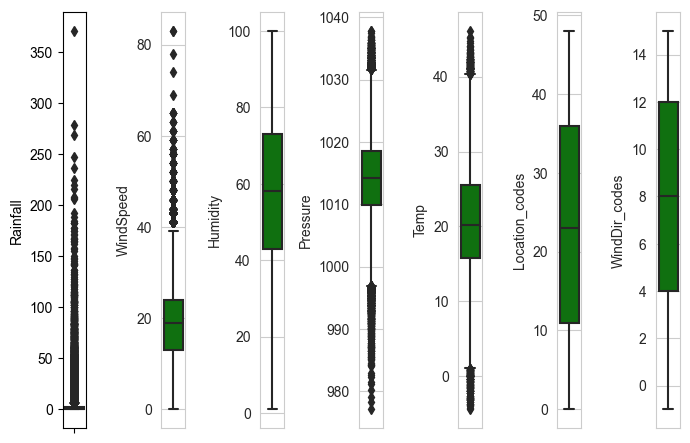

In [42]:
displayBoxPlots(data_train_reduced.select_dtypes(exclude='object'))

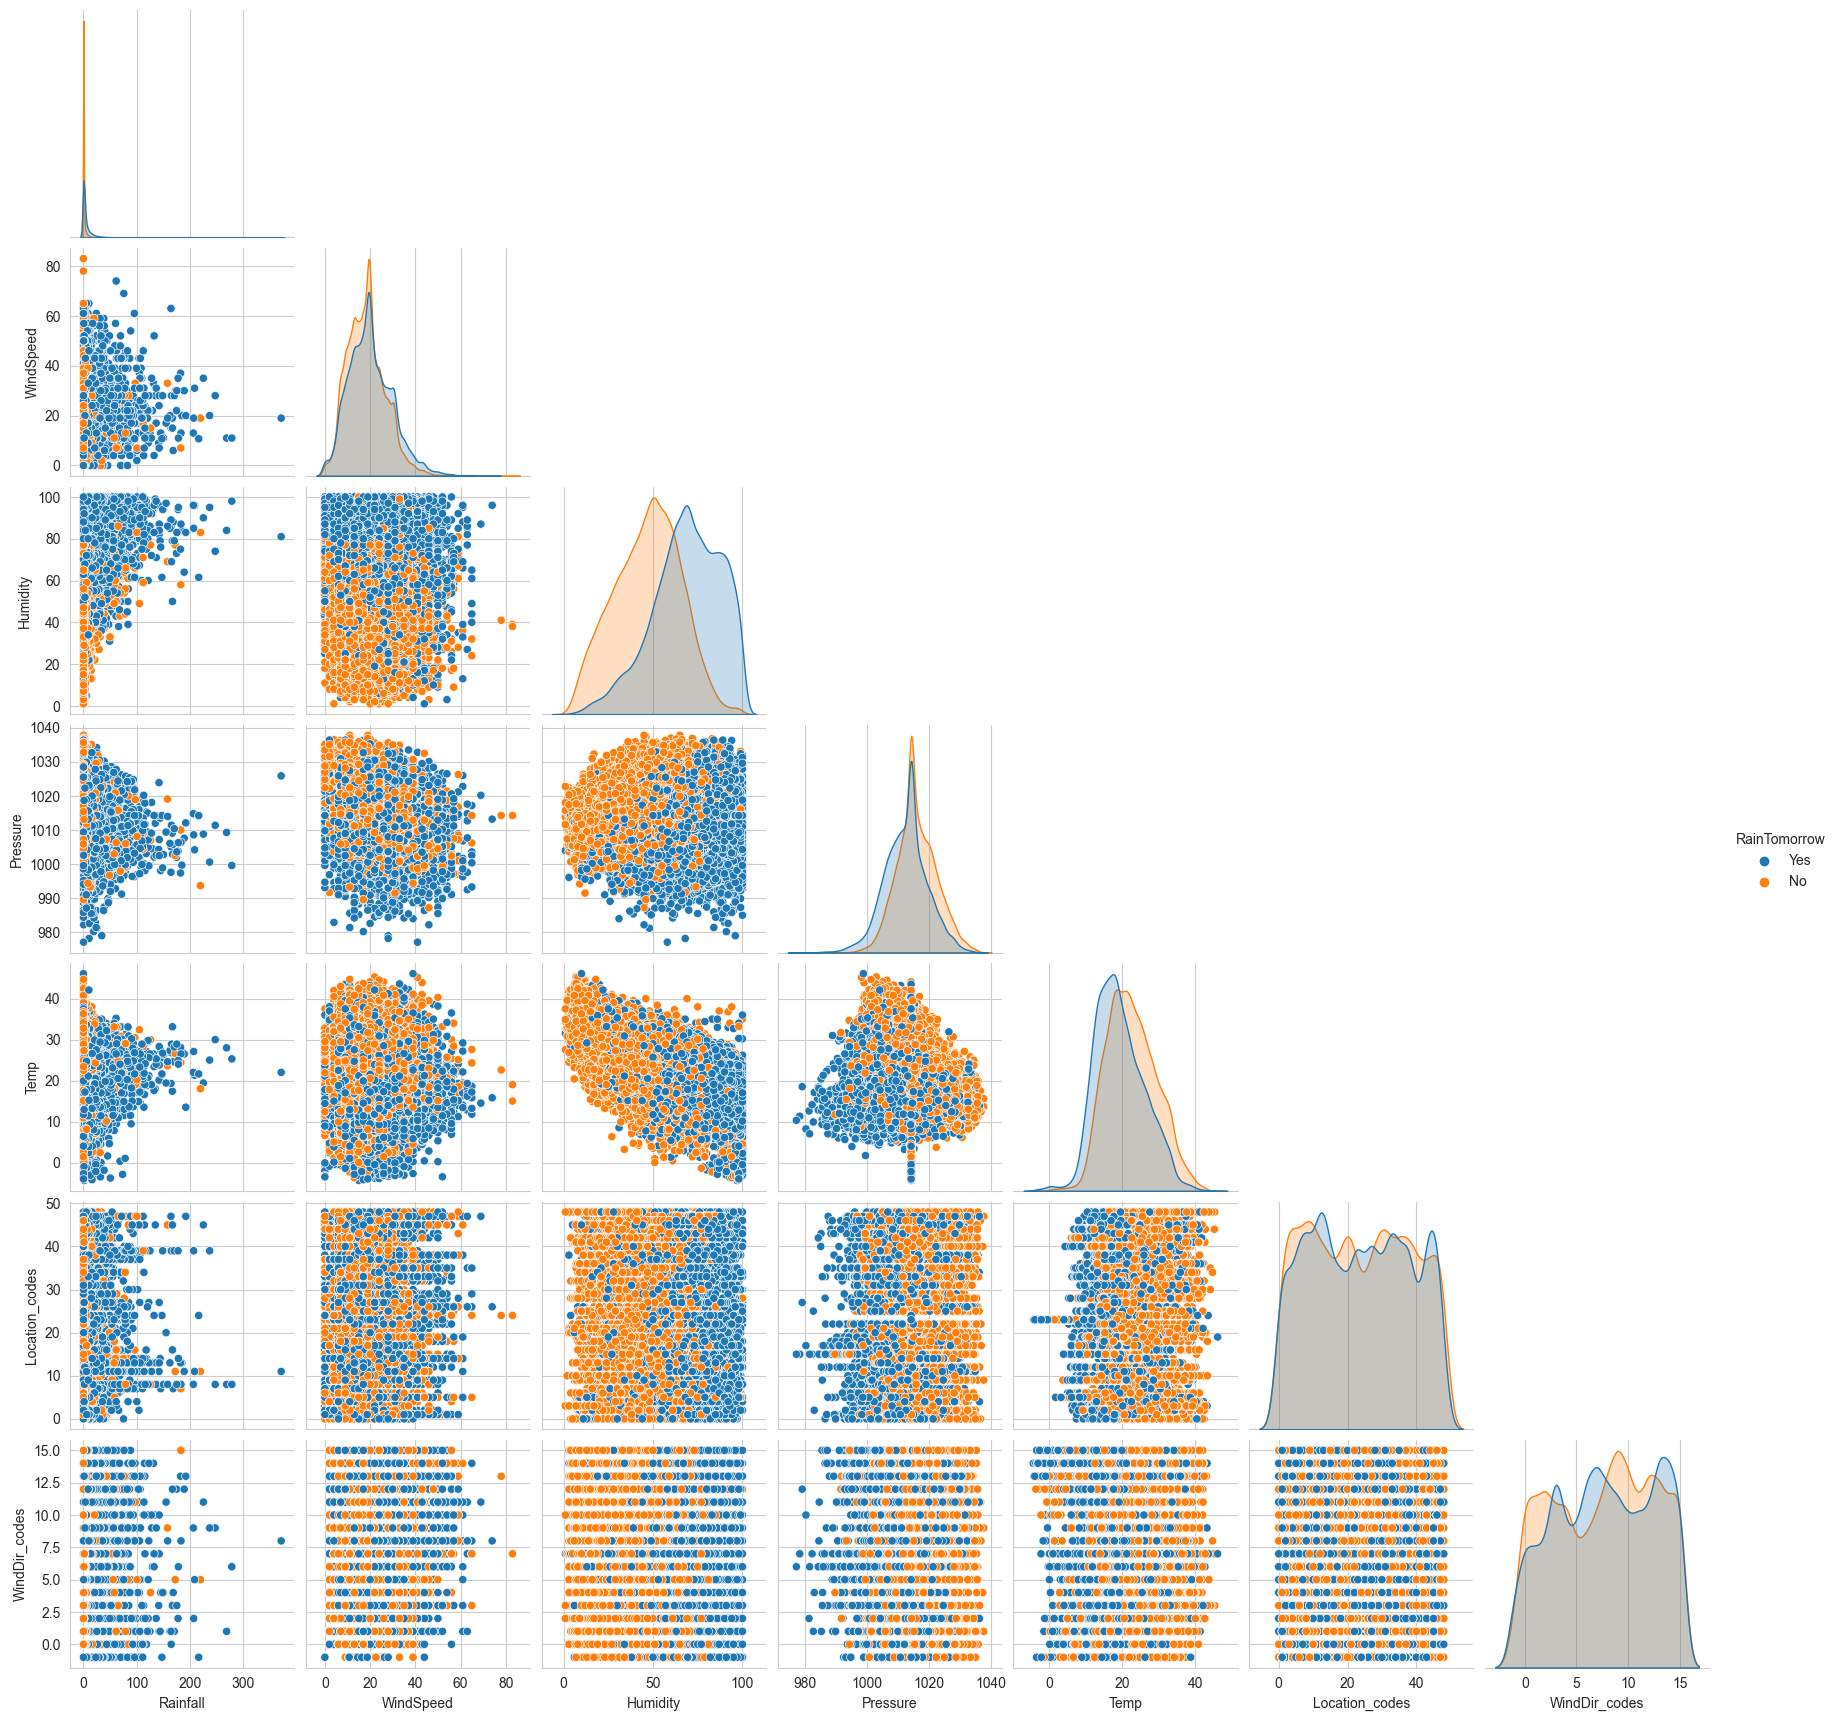

In [ ]:
sns.pairplot(data_train_reduced, hue="RainTomorrow", corner=True)

From the boxplots, we can see that any amount of rainfall is likely an outlier, while the other attributes have far less outliers and a wider distribution of values.

From the pair plots, we can see that a distinction can be formed for identifying the RainTomorrow target (with orange now values falling to one side and blue yes values falling to the other side).

 Let's finally look at the target class distribution.

In [ ]:
data_train_reduced.describe(include='object')

We can see that there is more or less an even spread between the data for the RainTomorrow target class variable which is really good for evaluating metrics.

## Section 2: Build, tune and evaluate decision tree models

### Model Selection and Tuning

 * binarizing target class label - mapping yes and no values

In [ ]:
data_train_reduced.head()

,Rainfall,WindSpeed,Humidity,Pressure,Temp,RainTomorrow,Location_codes,WindDir_codes
0,0.0,28.0,55.0,1026.0,22.4,Yes,26,10
1,0.0,26.0,48.0,1014.4,19.5,No,28,15
2,17.6,9.0,99.0,1028.5,17.8,Yes,14,12
3,0.0,19.0,55.0,1023.0,14.2,Yes,6,14
4,0.0,7.0,40.0,1027.1,22.5,No,43,2


In [46]:
lb = preprocessing.LabelBinarizer()
data_train_reduced['RainTomorrow'] = lb.fit_transform(data_train_reduced['RainTomorrow'])

In [47]:
data_train_reduced.head()

,Rainfall,WindSpeed,Humidity,Pressure,Temp,RainTomorrow,Location_codes,WindDir_codes
0,0.0,28.0,55.0,1026.0,22.4,1,26,10
1,0.0,26.0,48.0,1014.4,19.5,0,28,15
2,17.6,9.0,99.0,1028.5,17.8,1,14,12
3,0.0,19.0,55.0,1023.0,14.2,1,6,14
4,0.0,7.0,40.0,1027.1,22.5,0,43,2


Since decision tree models are based on a feature threshhold, they do not require feature scaling has this would not really have a significant effect. We will proceed with selecting the model.

 * splitting training data into training and validation datasets

In [48]:
X = data_train_reduced.drop('RainTomorrow', axis=1)
y = data_train_reduced['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Training data size is {X_train.shape}, and Validation data size is {X_test.shape}")

Training data size is (41345, 7), and Validation data size is (10337, 7)


 * setting up empty classification model context

In [49]:
clf_dt = DecisionTreeClassifier()

 * extensively test different models according to different hyper parameters

In [50]:
param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 3, 4, 5, 10, 20],
              'max_depth': [5, 10, 15, 20, 25, 30],
              'min_samples_leaf': [1, 2, 3, 4, 5, 10],
              'max_leaf_nodes': [2, 3, 4, 5, 10, 20, 25, 30]}

grid = GridSearchCV(
    clf_dt,
    param_grid, 
    cv=10, 
    scoring=[
        'accuracy',
        'f1',
        'roc_auc'
    ],
    n_jobs=-1,
    refit='f1'
)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'max_leaf_nodes': [2, 3, 4, 5, 10, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 10],
                         'min_samples_split': [2, 3, 4, 5, 10, 20]},
             refit='f1', scoring=['accuracy', 'f1', 'roc_auc'])

In [51]:
print(grid.best_score_) # f1-score

0.7486669877682451


All of the parameter variations were selected keeping in mind that the number of features being used is low, smaller values have been added in the range of 2 through 5, and the larger values were left in case these features are repeated as child nodes. The 'cv' parameter is where cross validation splitting is passed into grid search, and here it is set to 10 folds. Additionally, the best model would be selected based on the f1 score, rather than accuracy although we don't have to worry about imbalance as the target in the training data is evenly split.

**Output Best Model Hyperparameters**

In [52]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_leaf_nodes': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [53]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=25)

We can see that 'entropy' was selected along the values for the other hyperparameters. Let's now pass these values as arguments in our new decision tree classifier context which will be used to predict the values on our validation dataset.

In [54]:
clf_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    max_leaf_nodes=25,
    min_samples_leaf=1,
    min_samples_split=2
)

In [55]:
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=25)

 * let's quickly visualize the decision tree model to gain an understanding of how the algorithm processed our data.

In [56]:
text_model = export_text(
    clf_dt,
    feature_names=list(X_train.columns)
)

In [57]:
print(text_model)

|--- Humidity <= 63.50
|   |--- Rainfall <= 0.35
|   |   |--- Pressure <= 1011.05
|   |   |   |--- Humidity <= 25.50
|   |   |   |   |--- class: 0
|   |   |   |--- Humidity >  25.50
|   |   |   |   |--- Pressure <= 1004.25
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Pressure >  1004.25
|   |   |   |   |   |--- Humidity <= 50.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Humidity >  50.00
|   |   |   |   |   |   |--- class: 1
|   |   |--- Pressure >  1011.05
|   |   |   |--- Humidity <= 50.06
|   |   |   |   |--- Pressure <= 1018.25
|   |   |   |   |   |--- Humidity <= 26.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Humidity >  26.50
|   |   |   |   |   |   |--- WindDir_codes <= 7.50
|   |   |   |   |   |   |   |--- WindDir_codes <= 2.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- WindDir_codes >  2.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- WindDir_codes >  7.50
|  

The Rainfall values were initially dropped. Another approach was tried where -1 values that were used to replace the null values in rainfall, but they were getting lumped together with 0 values, and so the mean by location was used finally. Interestingly, we can see that only features were used to build the tree, excluding Temp, Location_codes, and WindSpeed with the algorithm set to split using the 'best' method rather than 'random'.

* predict target using best estimator (model with best parameter)

In [58]:
y_pred = clf_dt.predict(X_test)

### Model Performance Evaluation

Let's evaluate the model starting with confusion matrix.

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [60]:
print(tn, fp, fn, tp)

3958 1267 1264 3848


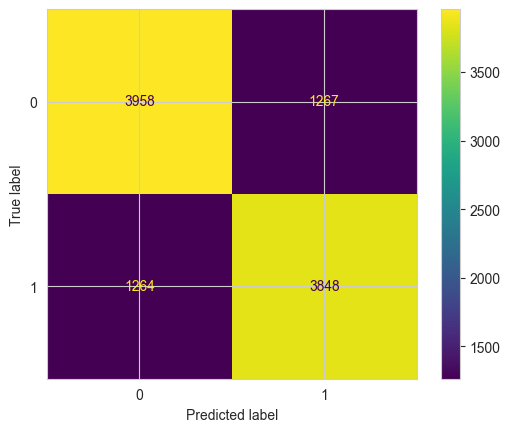

In [61]:
ConfusionMatrixDisplay.from_estimator(clf_dt, X_test, y_test)
# plot_confusion_matrix(clf_dt, X_test, y_test)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5225
           1       0.75      0.75      0.75      5112

    accuracy                           0.76     10337
   macro avg       0.76      0.76      0.76     10337
weighted avg       0.76      0.76      0.76     10337



We can see that the f1 score follows accuracy and there is no need to adjust the score for any imbalance. Here, precision is the number of times RainTomorrow is actually correct out of all the times that the model thought it would rain tomorrow, and recall is the number of times RainTomorrow is correct out of all the times it actually rained tomorrow. For both scenarios, the f1 score (harmonic mean of precision and recall) is the approx. the same at 75-76% (76% for accuracy). Although this is expected to be lower for the unseen test data. Additionally, both type 1 and type 2 errors are roughly the same as well.

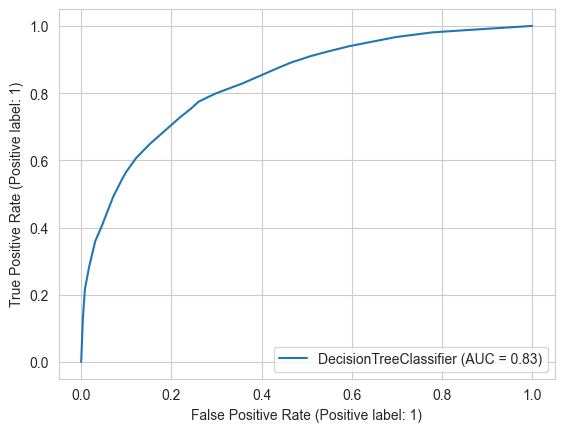

In [63]:
RocCurveDisplay.from_estimator(clf_dt, X_test, y_test)
# plot_roc_curve(clf_dt, X_test, y_test)

In [64]:
print(roc_auc_score(y_test, y_pred))

0.7551253079347964


It can be stated that the model has a 75.5% chance of distinguishing between 'yes' and 'no' for whether it will rain tomorrow. Since we are not placing any emphasis on one type of error over the other, we can use confidently use the roc auc score with the default 'macro' average method to evaluate model performance.

## Section 3: Model prediction

#### Unseen Testing Dataset Prediction

Steps:
 1. pre-processing testing dataset to follow training dataset
 2. making prediction
 3. saving result to file

### Pre-processing the Test Dataset

In [65]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12994 entries, 0 to 12993
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             12994 non-null  int64  
 1   Location       12994 non-null  object 
 2   MinTemp        12947 non-null  float64
 3   MaxTemp        12976 non-null  float64
 4   Rainfall       12833 non-null  float64
 5   Evaporation    7478 non-null   float64
 6   Sunshine       6900 non-null   float64
 7   WindGustDir    12065 non-null  object 
 8   WindGustSpeed  12074 non-null  float64
 9   WindDir        12607 non-null  object 
 10  WindSpeed      12733 non-null  float64
 11  Humidity       12645 non-null  float64
 12  Pressure       11701 non-null  float64
 13  Cloud          7974 non-null   float64
 14  Temp           12727 non-null  float64
 15  RainToday      12833 non-null  object 
dtypes: float64(11), int64(1), object(4)
memory usage: 1.6+ MB


In [66]:
data_test.shape

(12994, 16)

We will now perform the same pre-processing steps done on the training dataset:
 1. map categorical features to numerical values
 2. drop features - feature reduction
 3. replace null values with mean of that location group

In [67]:
mapped_columns = list(splitByType(data_test)['object_type'].columns)

In [68]:
for col in mapped_columns:
    data_test[col] = data_test[col].astype('category')

In [69]:
for col in mapped_columns:
    code_col = col + "_codes"
    data_test[code_col] = data_test[col].cat.codes

In [70]:
data_test_processed = data_test.drop(columns=[
    "MinTemp",
    "MaxTemp",
    "Evaporation",
    "Sunshine",
    "RainToday",
    "RainToday_codes",
    "WindGustSpeed",
    "WindGustDir",
    "WindGustDir_codes",
    "Location",
    "WindDir",
    "Cloud"
])

In [71]:
data_test_processed.isna().sum()

ID                   0
Rainfall           161
WindSpeed          261
Humidity           349
Pressure          1293
Temp               267
Location_codes       0
WindDir_codes        0
dtype: int64

In [72]:
data_test_processed.select_dtypes(exclude='object').columns[1:-2]

Index(['Rainfall', 'WindSpeed', 'Humidity', 'Pressure', 'Temp'], dtype='object')

In [73]:
for col in data_test_processed.select_dtypes(exclude='object').columns[1:-2]:
    data_test_processed[col] = data_test_processed.groupby('Location_codes')[col].transform(lambda x: x.fillna(x.mean()))
    print(f"{col} : {data_test_processed[col].isna().sum()}")

Rainfall : 0
WindSpeed : 0
Humidity : 0
Pressure : 1103
Temp : 0


In [74]:
data_test_processed.isna().sum()

ID                   0
Rainfall             0
WindSpeed            0
Humidity             0
Pressure          1103
Temp                 0
Location_codes       0
WindDir_codes        0
dtype: int64

In [75]:
data_test_processed[data_test_processed['Pressure'].isnull() == True]['Location_codes'].unique()

array([23, 24, 30, 36], dtype=int8)

In [76]:
data_test_processed['Pressure'].mean()

1014.1873012050403

In [77]:
data_test_processed['Pressure'].fillna(data_test_processed['Pressure'].mean(), inplace=True)

In [78]:
data_test_processed.isna().sum()

ID                0
Rainfall          0
WindSpeed         0
Humidity          0
Pressure          0
Temp              0
Location_codes    0
WindDir_codes     0
dtype: int64

In [79]:
id_ = data_test_processed['ID']

In [80]:
data_test_processed.drop('ID', axis=1, inplace=True)

### Predicting RainTomorrow from the Test Dataset

 * setting up a new decision tree classifier context for the testing dataset and training the model 

In [81]:
clf_test_unseen = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    max_leaf_nodes=25,
    min_samples_leaf=1,
    min_samples_split=2
)

In [82]:
clf_test_unseen.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=25)

 * predicting on the test data and creating a data frame with the results

In [83]:
y_pred_unseen = clf_test_unseen.predict(data_test_processed)

In [84]:
results = pd.DataFrame(zip(id_,y_pred_unseen), columns=['ID','DT'])

In [85]:
results.head()

,ID,DT
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


 * storing results to csv file where 1 is Yes and 0 is No for prediction

In [86]:
results.to_csv("prediction.csv", index=False)

## Additional Considerations

 * Imputing data using better methods (like clustering for example)
 * Comparing DecisionTreeClassifier against the RandomForestClassifier would be insightful
 * Adding a column stating which data points contain outliers (1=True, 0=False) could help the algorithm better learn
 * In sample and out of sample comparison (validation dataset vs. testing dataset once we do get actual values - not feasible for this assignment)
 * Also compute other scores (kappa) to evaluate the model
 * Impute Sunshine, Cloud, Evaporation if possible, could help with improving the model accuracy as there is more discrimination between the classes for these attributes